# Instalasi & Import

In [1]:
# Cell 1: Install & Import
# Instalasi library yang diperlukan
!pip install -q xgboost optuna shap

import os
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import shap
import plotly.io as pio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectFromModel

from optuna.samplers import TPESampler, NSGAIISampler, RandomSampler
from optuna.pruners import SuccessiveHalvingPruner, MedianPruner
from xgboost.callback import TrainingCallback

# Konfigurasi Lingkungan
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
pio.renderers.default = "iframe" # Agar grafik interaktif muncul di Kaggle

print("✅ Setup Selesai.")
print(f"🔹 XGBoost Version: {xgb.__version__} (Target: v3.0+)")
print(f"🔹 Optuna Version: {optuna.__version__}")
print(f"🔹 GPU Status: {'Aktif (CUDA)' if xgb.build_info()['USE_CUDA'] else 'Tidak Terdeteksi!'}")

✅ Setup Selesai.
🔹 XGBoost Version: 3.1.0 (Target: v3.0+)
🔹 Optuna Version: 2.10.1
🔹 GPU Status: Aktif (CUDA)


# Load Dataset (Otomatis)

In [2]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

# Cell 2: Load Data & Initial Split (Khusus NF-UNSW-NB15-v3)
print("📂 Mencari file dataset NF-UNSW-NB15-v3 di /kaggle/input/ ...")

data_path = None

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # Filter: Cari CSV, harus ada 'NF' dan 'UNSW', abaikan file 'features'
        if "csv" in filename.lower() and "unsw" in filename.lower() and "features" not in filename.lower():
            print(f"✅ Ditemukan File Data Utama: {filename}")
            data_path = os.path.join(dirname, filename)
            break # Ambil satu saja

if data_path:
    print(f"⏳ Sedang membaca dataset (bisa memakan waktu karena file besar)...")
    
    # Load seluruh data
    df_full = pd.read_csv(data_path)
    print(f"🔹 Total Data Terbaca: {df_full.shape}")

    # --- PENTING: CEK KOLOM TARGET ---
    # Biasanya 'Attack' (Nama Serangan) atau 'Label' (0/1).
    # Kita prioritaskan 'Attack' untuk Multiclass.
    target_col_raw = 'Attack' if 'Attack' in df_full.columns else 'Label'
    print(f"🎯 Menggunakan kolom target awal: {target_col_raw}")

    # --- SPLIT TRAIN & TEST (80:20) ---
    print("✂️  Membagi dataset menjadi Training dan Testing (80:20)...")
    
    # Stratify agar proporsi serangan langka (Worms, Analysis) seimbang
    df_train_full, df_test_raw = train_test_split(
        df_full, 
        test_size=0.2, 
        random_state=42, 
        stratify=df_full[target_col_raw]
    )
    
    # Bersihkan memori
    del df_full
    import gc
    gc.collect()

    print(f"✅ Training Data Siap: {df_train_full.shape}")
    print(f"✅ Testing Data Siap:  {df_test_raw.shape}")
    
else:
    raise FileNotFoundError("❌ File data NF-UNSW-NB15 tidak ditemukan! Cek input Kaggle Anda.")

📂 Mencari file dataset NF-UNSW-NB15-v3 di /kaggle/input/ ...
✅ Ditemukan File Data Utama: NF-UNSW-NB15-v3.csv
⏳ Sedang membaca dataset (bisa memakan waktu karena file besar)...
🔹 Total Data Terbaca: (2365424, 55)
🎯 Menggunakan kolom target awal: Attack
✂️  Membagi dataset menjadi Training dan Testing (80:20)...
✅ Training Data Siap: (1892339, 55)
✅ Testing Data Siap:  (473085, 55)


# Preprocessing & Class Weights

In [24]:
# Cell 3: Preprocessing (BERSIH, AMAN & OTOMATIS)
# Perbaikan: Menangani Infinity & NaN Values

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

# --- 1. KONFIGURASI TARGET ---
# Kita cari kolom target otomatis
possible_targets = ['Attack', 'attack_cat', 'Label'] 
target_col = next((col for col in possible_targets if col in df_train_full.columns), 'Label')

print(f"🎯 Target Kolom Final: '{target_col}'")

# --- 2. BERSIHKAN KOLOM IDENTITAS (WAJIB UTK NETFLOW) ---
cols_to_drop = [
    'id', 'ID', 
    'IPV4_SRC_ADDR', 'IPV4_DST_ADDR',   
    'L4_SRC_PORT', 'L4_DST_PORT',       
    'Timestamp',                        
    'Label',                            
    'dataset'                           
]

# Pastikan kita tidak membuang kolom target kita sendiri
if target_col in cols_to_drop:
    cols_to_drop.remove(target_col)

# Eksekusi Drop
df_train_clean = df_train_full.drop(columns=cols_to_drop, errors='ignore')
df_test_clean = df_test_raw.drop(columns=cols_to_drop, errors='ignore')

# --- 3. PISAHKAN FITUR (X) & TARGET (y) ---
X_raw = df_train_clean.drop(columns=[target_col], errors='ignore')
y_raw = df_train_clean[target_col]

X_test_final_raw = df_test_clean.drop(columns=[target_col], errors='ignore')
y_test_final_raw = df_test_clean[target_col]

# --- 4. ENCODING FITUR KATEGORIKAL ---
cat_cols = X_raw.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    print(f"🔤 Encoding fitur kategorikal: {list(cat_cols)}")
    for col in cat_cols:
        le = LabelEncoder()
        full_col = pd.concat([X_raw[col], X_test_final_raw[col]], axis=0).astype(str)
        le.fit(full_col)
        X_raw[col] = le.transform(X_raw[col].astype(str))
        X_test_final_raw[col] = le.transform(X_test_final_raw[col].astype(str))

# --- [PERBAIKAN UTAMA] 5. PEMBERSIHAN DATA (CLEANING) ---
print("🧹 Membersihkan Infinity dan NaN values...")

# A. Ganti Infinity dengan NaN
X_raw = X_raw.replace([np.inf, -np.inf], np.nan)
X_test_final_raw = X_test_final_raw.replace([np.inf, -np.inf], np.nan)

# B. Isi NaN dengan Median (Lebih aman daripada Mean untuk data jaringan yang miring)
# Kita simpan median dari training data untuk dipakai juga di test data
train_medians = X_raw.median()
X_raw = X_raw.fillna(train_medians)
X_test_final_raw = X_test_final_raw.fillna(train_medians)

# C. Cek apakah masih ada error
if np.isinf(X_raw).values.sum() > 0 or X_raw.isnull().values.sum() > 0:
    print("⚠️ Masih ada nilai bermasalah! Melakukan pemaksaan 0.")
    X_raw = X_raw.fillna(0)
    X_test_final_raw = X_test_final_raw.fillna(0)

print("✅ Data bersih dari Infinity.")

# --- 6. ENCODING TARGET (LABEL) ---
le_target = LabelEncoder()
y = le_target.fit_transform(y_raw)
y_test_final = le_target.transform(y_test_final_raw)

# --- 7. SCALING (STANDARISASI) ---
print("📏 Melakukan Scaling data...")
scaler = StandardScaler()

# Sekarang aman karena tidak ada inf/nan
X_enc = pd.DataFrame(scaler.fit_transform(X_raw), columns=X_raw.columns)
X_test_enc = pd.DataFrame(scaler.transform(X_test_final_raw), columns=X_test_final_raw.columns)

# Optimasi Memori (Float32)
float_cols = X_enc.select_dtypes(include=['float64']).columns
X_enc[float_cols] = X_enc[float_cols].astype('float32')
X_test_enc[float_cols] = X_test_enc[float_cols].astype('float32')

# Finalisasi Data
X_selected = X_enc
X_test_selected = X_test_enc

print(f"✅ Dataset Siap Proses.")
print(f"🔹 Jumlah Fitur: {X_selected.shape[1]}")
print(f"🔹 Daftar Kelas: {le_target.classes_}")

# --- 8. SPLIT VALIDATION SET ---
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# --- 9. AUTO-WEIGHTING (HYBRID STRATEGY) ---
print("\n⚖️ Menghitung Bobot Kelas (Otomatis)...")
raw_weights = compute_sample_weight(class_weight='balanced', y=y_train)
sample_weights_train = np.sqrt(raw_weights)
sample_weights_train = sample_weights_train / sample_weights_train.mean()

print(f"✅ Bobot Selesai.")
print(f"🔹 Min Weight: {sample_weights_train.min():.4f}")
print(f"🔹 Max Weight: {sample_weights_train.max():.4f}")

print(f"\n🔹 Train Set: {X_train.shape}")
print(f"🔹 Val Set:   {X_val.shape}")

🎯 Target Kolom Final: 'Attack'
🧹 Membersihkan Infinity dan NaN values...
✅ Data bersih dari Infinity.
📏 Melakukan Scaling data...
✅ Dataset Siap Proses.
🔹 Jumlah Fitur: 49
🔹 Daftar Kelas: ['Analysis' 'Backdoor' 'Benign' 'DoS' 'Exploits' 'Fuzzers' 'Generic'
 'Reconnaissance' 'Shellcode' 'Worms']

⚖️ Menghitung Bobot Kelas (Otomatis)...
✅ Bobot Selesai.
🔹 Min Weight: 0.6590
🔹 Max Weight: 78.4768

🔹 Train Set: (1513871, 49)
🔹 Val Set:   (378468, 49)


# Visualisasi Data: Distribusi Kelas & Bobot

📊 Visualisasi Distribusi Data & Strategi Penanganan Imbalance...


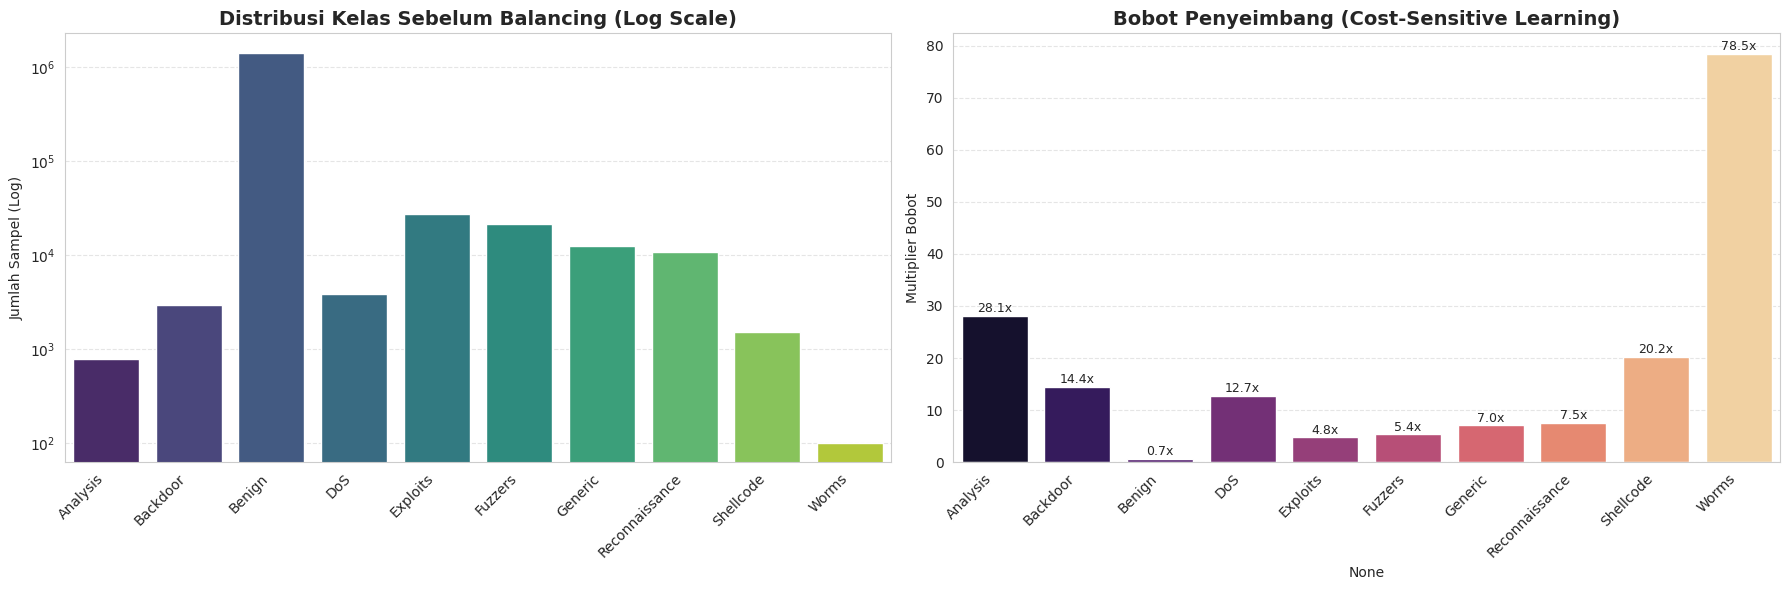

✅ Interpretasi Skripsi: Grafik kiri menunjukkan ketimpangan data. Grafik kanan menunjukkan bagaimana model 'memaksa' perhatian lebih ke kelas minoritas.


In [4]:
# Cell Tambahan (Awal): Visualisasi Imbalance & Bobot Penyeimbang
# Jalankan ini setelah Cell 3 selesai
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("📊 Visualisasi Distribusi Data & Strategi Penanganan Imbalance...")

# 1. Hitung jumlah sampel per kelas di Training Set
class_counts = pd.Series(y_train).value_counts().sort_index()
class_names = le_target.classes_

# 2. Ambil contoh bobot yang sudah dihitung di Cell 3
# Kita ambil bobot unik per kelas untuk visualisasi
unique_weights = {}
for label_idx in class_counts.index:
    # Cari indeks pertama sample dengan label tersebut
    idx = np.where(y_train == label_idx)[0][0]
    unique_weights[class_names[label_idx]] = sample_weights_train[idx]

weights_series = pd.Series(unique_weights)

# 3. Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot A: Distribusi Jumlah Data (Log Scale)
sns.barplot(x=class_names, y=class_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Distribusi Kelas Sebelum Balancing (Log Scale)", fontsize=14, fontweight='bold')
axes[0].set_yscale("log") # Penting agar kelas minoritas terlihat
axes[0].set_ylabel("Jumlah Sampel (Log)")
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Plot B: Bobot yang Diberikan (Inverse Frequency)
sns.barplot(x=weights_series.index, y=weights_series.values, ax=axes[1], palette="magma")
axes[1].set_title("Bobot Penyeimbang (Cost-Sensitive Learning)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Multiplier Bobot")
axes[1].set_xticklabels(weights_series.index, rotation=45, ha='right')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Anotasi nilai bobot
for i, v in enumerate(weights_series.values):
    axes[1].text(i, v + 0.1, f"{v:.1f}x", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✅ Interpretasi Skripsi: Grafik kiri menunjukkan ketimpangan data. Grafik kanan menunjukkan bagaimana model 'memaksa' perhatian lebih ke kelas minoritas.")

# Definisi Objective Function (Generic)

In [5]:
# Cell 4: Objective Function Multi-Objective (F1 vs Inference Time)
import time
import xgboost as xgb
from sklearn.metrics import f1_score

def objective_xgboost_multi(trial):
    # --- HYPERPARAMETERS ---
    param = {
        # Parameter Booster
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        
        # Parameter Struktur Pohon
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 3),
        'max_delta_step': trial.suggest_int('max_delta_step', 1, 8),
        
        # Parameter Regularisasi & Sampling
        'gamma': trial.suggest_float('gamma', 0.1, 0.5),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1.0, log=True),
        
        # Fixed Params (Wajib untuk GPU & Multiclass)
        'objective': 'multi:softmax', 
        'num_class': len(le_target.classes_),
        'tree_method': 'hist',
        'device': 'cuda', # Pastikan GPU aktif
        'verbosity': 0
    }

    # Inisialisasi Model
    model = xgb.XGBClassifier(**param, random_state=42)
    
    # Training
    model.fit(
        X_train, y_train,
        sample_weight=sample_weights_train, # Penanganan Imbalance
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # --- PENGUKURAN (2 Target) ---
    
    # 1. Inference Time (Minimize)
    # Ukur waktu prediksi data validasi
    start_time = time.perf_counter()
    preds = model.predict(X_val)
    inference_time = time.perf_counter() - start_time
    
    # 2. Macro F1-Score (Maximize)
    f1 = f1_score(y_val, preds, average='macro')
    
    # Return: (F1, Time)
    return f1, inference_time

# Strategi 1 - Optuna TPE (Tree-structured Parzen Estimator)

In [6]:
# Cell 5: Eksekusi TPE (Bayesian Multi-Objective)
import optuna
from optuna.samplers import TPESampler

print("🚀 [1/3] Memulai TPE (Bayesian Optimization)...")
start_tpe = time.time()

# Directions: Maximize F1, Minimize Time
study_tpe = optuna.create_study(
    directions=['maximize', 'minimize'], 
    sampler=TPESampler(seed=42)
)

study_tpe.optimize(objective_xgboost_multi, n_trials=30) # Sesuaikan n_trials
time_tpe = time.time() - start_tpe

print(f"✅ TPE Selesai dalam: {time_tpe:.2f} detik.")
print(f"🔹 Jumlah Solusi Pareto: {len(study_tpe.best_trials)}")

[I 2026-01-01 21:23:35,423] A new study created in memory with name: no-name-bc4ef109-64e3-44ea-82c0-5e26387bd660


🚀 [1/3] Memulai TPE (Bayesian Optimization)...


[I 2026-01-01 21:25:59,970] Trial 0 finished with values: [0.7710603118431135, 2.7530240269998103] and parameters: {'n_estimators': 1062, 'learning_rate': 0.2536999076681772, 'max_depth': 11, 'min_child_weight': 2, 'max_delta_step': 2, 'gamma': 0.16239780813448107, 'subsample': 0.6203292642588698, 'colsample_bytree': 0.846470458309974, 'reg_alpha': 0.004042872735027332, 'reg_lambda': 0.017718847354806822}. 
[I 2026-01-01 21:27:17,195] Trial 1 finished with values: [0.7734410477970409, 1.50465238400011] and parameters: {'n_estimators': 530, 'learning_rate': 0.2708160864249968, 'max_depth': 11, 'min_child_weight': 0, 'max_delta_step': 2, 'gamma': 0.17336180394137352, 'subsample': 0.7064847850358382, 'colsample_bytree': 0.7099025726528951, 'reg_alpha': 0.0003905441275210792, 'reg_lambda': 5.589524205217924e-05}. 
[I 2026-01-01 21:30:19,489] Trial 2 finished with values: [0.7878116088500509, 4.00122495100004] and parameters: {'n_estimators': 1418, 'learning_rate': 0.01607123851203988, 'max

✅ TPE Selesai dalam: 3554.11 detik.
🔹 Jumlah Solusi Pareto: 3


# Strategi 2 - Optuna NSGA-II (Genetic Algorithm)

In [7]:
# Cell 6: Eksekusi NSGA-II (Evolutionary Algorithm)
from optuna.samplers import NSGAIISampler

print("🚀 [2/3] Memulai NSGA-II (Genetic Algorithm)...")
start_nsga = time.time()

study_nsga = optuna.create_study(
    directions=['maximize', 'minimize'], 
    sampler=NSGAIISampler(seed=42)
)

study_nsga.optimize(objective_xgboost_multi, n_trials=30)
time_nsga = time.time() - start_nsga

print(f"✅ NSGA-II Selesai dalam: {time_nsga:.2f} detik.")
print(f"🔹 Jumlah Solusi Pareto: {len(study_nsga.best_trials)}")

[I 2026-01-01 22:22:49,543] A new study created in memory with name: no-name-38a8527b-8f30-40d0-8163-f67a4a27a4f8


🚀 [2/3] Memulai NSGA-II (Genetic Algorithm)...


[I 2026-01-01 22:25:13,751] Trial 0 finished with values: [0.7710603118431135, 2.7621530090000306] and parameters: {'n_estimators': 1062, 'learning_rate': 0.2536999076681772, 'max_depth': 11, 'min_child_weight': 2, 'max_delta_step': 2, 'gamma': 0.16239780813448107, 'subsample': 0.6203292642588698, 'colsample_bytree': 0.846470458309974, 'reg_alpha': 0.004042872735027332, 'reg_lambda': 0.017718847354806822}. 
[I 2026-01-01 22:26:31,113] Trial 1 finished with values: [0.7734410477970409, 1.4913721989996702] and parameters: {'n_estimators': 530, 'learning_rate': 0.2708160864249968, 'max_depth': 11, 'min_child_weight': 0, 'max_delta_step': 2, 'gamma': 0.17336180394137352, 'subsample': 0.7064847850358382, 'colsample_bytree': 0.7099025726528951, 'reg_alpha': 0.0003905441275210792, 'reg_lambda': 5.589524205217924e-05}. 
[I 2026-01-01 22:29:33,562] Trial 2 finished with values: [0.7878116088500509, 3.978789886999948] and parameters: {'n_estimators': 1418, 'learning_rate': 0.01607123851203988, '

✅ NSGA-II Selesai dalam: 4839.74 detik.
🔹 Jumlah Solusi Pareto: 5


# Strategi 3 - Optuna RandomSampler (Baseline)

In [8]:
# Cell 7: Eksekusi Random Search (Baseline)
from optuna.samplers import RandomSampler

print("🚀 [3/3] Memulai Random Search (Baseline Pembanding)...")
start_random = time.time()

study_random = optuna.create_study(
    directions=['maximize', 'minimize'], 
    sampler=RandomSampler(seed=42)
)

study_random.optimize(objective_xgboost_multi, n_trials=30)
time_random = time.time() - start_random

print(f"✅ Random Search Selesai dalam: {time_random:.2f} detik.")
print(f"🔹 Jumlah Solusi Pareto: {len(study_random.best_trials)}")

[I 2026-01-01 23:43:29,290] A new study created in memory with name: no-name-fb3542fe-3d31-46f0-83ce-b727181dd9a9


🚀 [3/3] Memulai Random Search (Baseline Pembanding)...


[I 2026-01-01 23:45:53,396] Trial 0 finished with values: [0.7710603118431135, 2.7874873710006796] and parameters: {'n_estimators': 1062, 'learning_rate': 0.2536999076681772, 'max_depth': 11, 'min_child_weight': 2, 'max_delta_step': 2, 'gamma': 0.16239780813448107, 'subsample': 0.6203292642588698, 'colsample_bytree': 0.846470458309974, 'reg_alpha': 0.004042872735027332, 'reg_lambda': 0.017718847354806822}. 
[I 2026-01-01 23:47:10,734] Trial 1 finished with values: [0.7734410477970409, 1.4994948800012935] and parameters: {'n_estimators': 530, 'learning_rate': 0.2708160864249968, 'max_depth': 11, 'min_child_weight': 0, 'max_delta_step': 2, 'gamma': 0.17336180394137352, 'subsample': 0.7064847850358382, 'colsample_bytree': 0.7099025726528951, 'reg_alpha': 0.0003905441275210792, 'reg_lambda': 5.589524205217924e-05}. 
[I 2026-01-01 23:50:13,277] Trial 2 finished with values: [0.7878116088500509, 3.986837058999299] and parameters: {'n_estimators': 1418, 'learning_rate': 0.01607123851203988, '

✅ Random Search Selesai dalam: 4841.58 detik.
🔹 Jumlah Solusi Pareto: 5


# Evaluasi Model Final & Komparasi

In [9]:
# Cell 8: Evaluasi Final (TPE vs NSGA-II vs Random) dengan Progress Log
import pandas as pd
import numpy as np
import time
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight

# --- Helper: Ambil parameter terbaik dari Pareto Front ---
def get_best_multiobj_params(study, name):
    print(f"🔍 Mengambil solusi terbaik {name}...")
    # Urutkan trial Pareto berdasarkan F1 tertinggi (Prioritas Akurasi)
    best_trials = sorted(study.best_trials, key=lambda t: t.values[0], reverse=True)
    best_trial = best_trials[0] # Juara 1
    return best_trial.params, best_trial.values[1] # Params & Est. Time

# --- Fungsi Training Ulang ---
def train_final(study, name):
    # 1. Ambil Params
    best_params, _ = get_best_multiobj_params(study, name)
    
    # 2. Update Fixed Params
    best_params.update({
        'objective': 'multi:softmax',
        'num_class': len(le_target.classes_),
        'tree_method': 'hist',
        'device': 'cuda',
        'verbosity': 0 # Supaya tidak spam warning, log training diatur di .fit()
    })
    
    # 3. Train Full Data (dengan Bobot Balanced)
    print(f"   ⏳ Mulai Training {name} pada Full Dataset ({best_params['n_estimators']} trees)...")
    model = xgb.XGBClassifier(**best_params, random_state=42)
    weights = np.sqrt(compute_sample_weight('balanced', y=y))
    
    # --- MODIFIKASI DISINI UNTUK PROGRESS ---
    model.fit(
        X_selected, y, 
        sample_weight=weights,
        # Kita gunakan data training sendiri sebagai eval_set untuk memantau penurunan Loss
        eval_set=[(X_selected, y)], 
        verbose=100  # Tampilkan log setiap 100 epoch
    )
    print(f"   ✅ Training {name} Selesai.")
    
    # 4. Inference Real pada Data Test
    print(f"   ⏱️ Mengukur Inference Time pada Data Test...")
    start = time.perf_counter()
    preds = model.predict(X_test_selected)
    real_time = time.perf_counter() - start
    
    return model, preds, real_time

# --- EKSEKUSI ---
results_list = []
# Dictionary untuk menyimpan model global agar bisa dipakai visualisasi
global_models = {} 

# List studi yang akan dievaluasi
# Pastikan variabel study_tpe, study_nsga, study_random SUDAH ADA dari cell sebelumnya
studies = []
if 'study_tpe' in locals(): studies.append(("TPE", study_tpe))
if 'study_nsga' in locals(): studies.append(("NSGA-II", study_nsga))
if 'study_random' in locals(): studies.append(("Random", study_random))

for name, study in studies:
    try:
        print(f"\n{'='*40}")
        print(f" PROSES METODE: {name}")
        print(f"{'='*40}")
        
        # Train & Eval
        model, preds, r_time = train_final(study, name)
        
        # Simpan ke global
        global_models[name] = (model, preds)
        
        # Ambil Waktu Optimasi (Trik eval nama variabel dynamic)
        # BUG FIX: Mapping manual agar aman
        time_var_map = {
            "TPE": "time_tpe",
            "NSGA-II": "time_nsga", # Pastikan ini mengarah ke time_nsga
            "Random": "time_random"
        }
        
        try:
            # Gunakan mapping, jangan eval string otomatis yang berisiko
            opt_time = eval(time_var_map[name]) if name in time_var_map else 0
        except:
            opt_time = 0
        
        # Simpan Metrics
        results_list.append({
            'Metode': name,
            'F1-Score (Macro)': f1_score(y_test_final, preds, average='macro'),
            'Accuracy': accuracy_score(y_test_final, preds),
            'Inference Time (s)': r_time,
            'Waktu Optimasi (s)': opt_time
        })
        
        print(f"\n📄 Classification Report: {name}")
        print(classification_report(y_test_final, preds, target_names=le_target.classes_))
        
    except Exception as e:
        print(f"⚠️ Gagal evaluasi {name}: {e}")

# Tampilkan Tabel Akhir dengan Styling Profesional
if results_list:
    results = pd.DataFrame(results_list).set_index('Metode')
    print("\n\n=== 🏆 HASIL AKHIR KOMPARASI (HIGHLIGHTED) ===")
    
    # Styling:
    # - F1 & Accuracy: Hijau (Makin tinggi makin hijau)
    # - Time: Merah (Makin tinggi makin merah/buruk)
    styled_results = results.style\
        .format("{:.4f}")\
        .background_gradient(subset=['F1-Score (Macro)', 'Accuracy'], cmap='Greens')\
        .background_gradient(subset=['Inference Time (s)', 'Waktu Optimasi (s)'], cmap='Reds')\
        .highlight_max(subset=['F1-Score (Macro)', 'Accuracy'], color='lightgreen', axis=0)\
        .highlight_min(subset=['Inference Time (s)', 'Waktu Optimasi (s)'], color='lightgreen', axis=0) # Waktu terendah di-highlight hijau
        
    display(styled_results)
else:
    print("❌ Tidak ada hasil yang dapat ditampilkan.")


 PROSES METODE: TPE
🔍 Mengambil solusi terbaik TPE...
   ⏳ Mulai Training TPE pada Full Dataset (500 trees)...
[0]	validation_0-mlogloss:1.64973
[100]	validation_0-mlogloss:0.02431
[200]	validation_0-mlogloss:0.01701
[300]	validation_0-mlogloss:0.01314
[400]	validation_0-mlogloss:0.01078
[499]	validation_0-mlogloss:0.00906
   ✅ Training TPE Selesai.
   ⏱️ Mengukur Inference Time pada Data Test...

📄 Classification Report: TPE
                precision    recall  f1-score   support

      Analysis       0.46      0.61      0.52       245
      Backdoor       0.93      0.92      0.93       932
        Benign       1.00      1.00      1.00    447546
           DoS       0.65      0.53      0.58      1196
      Exploits       0.87      0.82      0.84      8550
       Fuzzers       0.82      0.92      0.86      6763
       Generic       0.95      0.92      0.94      3930
Reconnaissance       0.83      0.78      0.80      3415
     Shellcode       0.66      0.83      0.74       476
        

,F1-Score (Macro),Accuracy,Inference Time (s),Waktu Optimasi (s)
Metode,,,,
TPE,0.7893,0.9915,1.7948,3554.1104
NSGA-II,0.7962,0.9917,4.3553,4839.7381
Random,0.7962,0.9917,4.3658,4841.5843


# Visualisasi A : Pareto Front Gabungan

In [10]:
# Cell 9: Visualisasi Pareto Front (Comparison)
import plotly.graph_objects as go
import optuna

fig = go.Figure()

def add_pareto_trace(study, name, color, symbol):
    if study is None: return
    # Ambil trial sukses
    trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    x = [t.values[1] for t in trials] # Time
    y = [t.values[0] for t in trials] # F1
    
    fig.add_trace(go.Scatter(
        x=x, y=y, mode='markers', name=name,
        marker=dict(size=9, color=color, symbol=symbol, opacity=0.7)
    ))

add_pareto_trace(study_nsga, "NSGA-II", "red", "circle")
add_pareto_trace(study_tpe, "TPE", "blue", "x")
add_pareto_trace(study_random, "Random (Baseline)", "gray", "square")

fig.update_layout(
    title='<b>Pareto Front Comparison:</b> Intelligent Search vs Random Baseline',
    xaxis_title='Inference Time (s) [Makin Kecil Bagus]',
    yaxis_title='Macro F1-Score [Makin Besar Bagus]',
    template='plotly_white'
)
fig.show()

# Visualisasi B : Confusion Matrix Berdampingan (TPE, ASHA, NSGA-II)

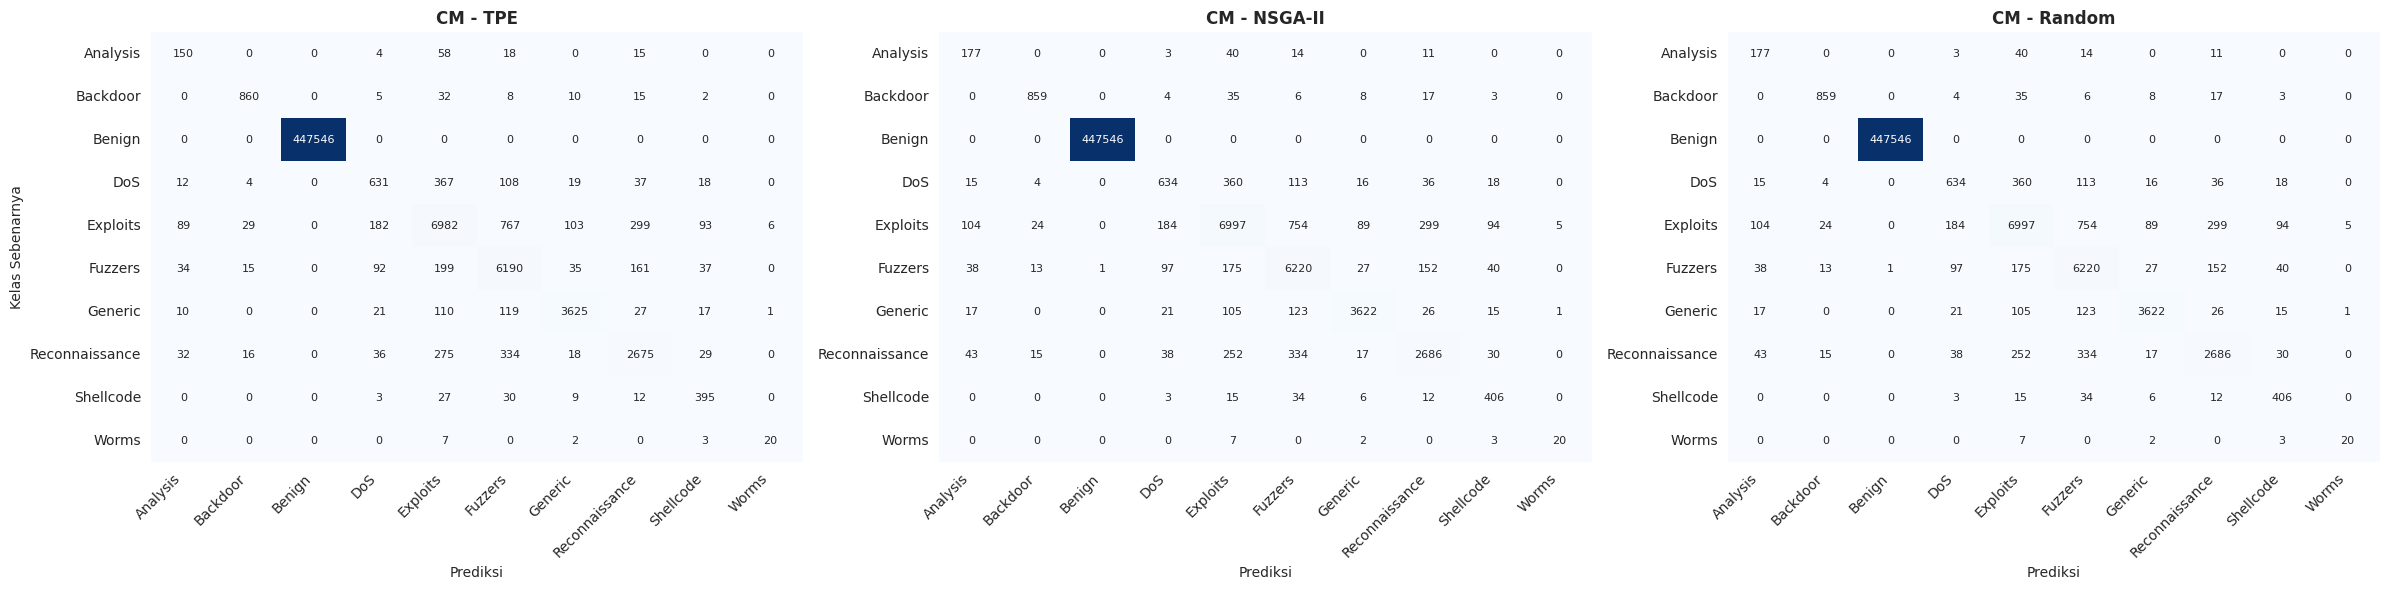

In [11]:
# Cell 10: Confusion Matrix Comparison
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    # Normalisasi
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=le_target.classes_, yticklabels=le_target.classes_,
                annot_kws={"size": 8})
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Prediksi')
    ax.set_xticklabels(le_target.classes_, rotation=45, ha='right')

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

methods_order = ["TPE", "NSGA-II", "Random"]
for i, name in enumerate(methods_order):
    if name in global_models:
        plot_cm(y_test_final, global_models[name][1], f"CM - {name}", axes[i])
    else:
        axes[i].axis('off')

axes[0].set_ylabel('Kelas Sebenarnya')
plt.tight_layout()
plt.show()

# Visualisasi C: Hyperparameter Importance (Analisis Faktor Penentu)

In [31]:
# Cell Diagnosa: Cek Status Study
import optuna

print("🔍 Mendiagnosa Status Study Optimasi...")

check_list = [
    ("TPE", 'study_tpe'),
    ("NSGA-II", 'study_nsga'),
    ("Random", 'study_random')
]

for name, var_name in check_list:
    if var_name in locals():
        study = locals()[var_name]
        # Hitung trial yang statusnya COMPLETE (Sukses)
        success_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
        count = len(success_trials)
        
        print(f"👉 {name}: Ditemukan {count} trial sukses.")
        
        if count == 0:
            print("   ⚠️ Peringatan: 0 Trial sukses. Anda harus menjalankan ulang Cell 5/6.")
        elif count < 5:
            print("   ⚠️ Peringatan: Data terlalu sedikit (<5) untuk Hyperparameter Importance.")
    else:
        print(f"❌ {name}: Variabel '{var_name}' TIDAK DITEMUKAN. (Anda belum menjalankan Cell 5/6/7).")

🔍 Mendiagnosa Status Study Optimasi...
👉 TPE: Ditemukan 30 trial sukses.
👉 NSGA-II: Ditemukan 30 trial sukses.
👉 Random: Ditemukan 30 trial sukses.


In [34]:
# Cell 11a: Analisis Hiperparameter TPE (Bayesian)
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import plotly.express as px
import optuna
from IPython.display import display

print("📊 [1/3] Menganalisis Faktor Penentu F1-Score pada TPE...")

# Ambil study TPE dengan aman
study = locals().get('study_tpe')

if study is not None:
    # 1. Filter Trial Sukses
    trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    n_trials = len(trials)
    
    if n_trials >= 5:
        # 2. Ekstrak Data
        data = []
        for t in trials:
            row = t.params.copy()
            row['target_f1'] = t.values[0] # Ambil F1
            data.append(row)
            
        df_imp = pd.DataFrame(data)
        
        # 3. Training RF (Variabel lokal, aman)
        X_imp = df_imp.drop(columns='target_f1')
        y_imp = df_imp['target_f1'] 
        
        if y_imp.nunique() > 1: # Cek apakah F1 bervariasi
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X_imp, y_imp)
            
            # 4. Visualisasi
            importance = pd.Series(rf.feature_importances_, index=X_imp.columns).sort_values(ascending=True)
            
            fig = px.bar(
                importance, x=importance.values, y=importance.index, orientation='h', 
                title="<b>TPE Importance:</b> Parameter Paling Berpengaruh ke F1-Score",
                labels={'x': 'Relative Importance', 'y': 'Parameter'},
                template='plotly_white', color_discrete_sequence=['#1f77b4'] # Biru
            )
            fig.update_layout(height=400, showlegend=False, margin=dict(l=150))
            display(fig)
        else:
            print("   ⚠️ Skor F1 identik semua (Flat). Tidak ada variasi untuk dianalisis.")
    else:
        print(f"   ⚠️ Data kurang (Hanya {n_trials} trial sukses). Butuh minimal 5.")
else:
    print("❌ Variabel 'study_tpe' tidak ditemukan. Jalankan Cell 5 dulu.")

📊 [1/3] Menganalisis Faktor Penentu F1-Score pada TPE...


In [35]:
# Cell 11b: Analisis Hiperparameter NSGA-II (Evolutionary)
print("📊 [2/3] Menganalisis Faktor Penentu F1-Score pada NSGA-II...")

study = locals().get('study_nsga')

if study is not None:
    trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    n_trials = len(trials)
    
    if n_trials >= 5:
        data = []
        for t in trials:
            row = t.params.copy()
            row['target_f1'] = t.values[0]
            data.append(row)
        
        df_imp = pd.DataFrame(data)
        X_imp = df_imp.drop(columns='target_f1')
        y_imp = df_imp['target_f1'] 
        
        if y_imp.nunique() > 1:
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X_imp, y_imp)
            
            importance = pd.Series(rf.feature_importances_, index=X_imp.columns).sort_values(ascending=True)
            
            fig = px.bar(
                importance, x=importance.values, y=importance.index, orientation='h', 
                title="<b>NSGA-II Importance:</b> Parameter Paling Berpengaruh ke F1-Score",
                labels={'x': 'Relative Importance', 'y': 'Parameter'},
                template='plotly_white', color_discrete_sequence=['#d62728'] # Merah
            )
            fig.update_layout(height=400, showlegend=False, margin=dict(l=150))
            display(fig)
        else:
            print("   ⚠️ Skor F1 identik semua. Tidak bisa analisis.")
    else:
        print(f"   ⚠️ Data kurang (Hanya {n_trials} trial sukses).")
else:
    print("❌ Variabel 'study_nsga' tidak ditemukan. Jalankan Cell 6 dulu.")

📊 [2/3] Menganalisis Faktor Penentu F1-Score pada NSGA-II...


In [36]:
# Cell 11c: Analisis Hiperparameter Random Search
print("📊 [3/3] Menganalisis Faktor Penentu F1-Score pada Random Search...")

study = locals().get('study_random')

if study is not None:
    trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    n_trials = len(trials)
    
    if n_trials >= 5:
        data = []
        for t in trials:
            row = t.params.copy()
            row['target_f1'] = t.values[0]
            data.append(row)
        
        df_imp = pd.DataFrame(data)
        X_imp = df_imp.drop(columns='target_f1')
        y_imp = df_imp['target_f1'] 
        
        if y_imp.nunique() > 1:
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            rf.fit(X_imp, y_imp)
            
            importance = pd.Series(rf.feature_importances_, index=X_imp.columns).sort_values(ascending=True)
            
            fig = px.bar(
                importance, x=importance.values, y=importance.index, orientation='h', 
                title="<b>Random Search Importance:</b> Parameter Paling Berpengaruh",
                labels={'x': 'Relative Importance', 'y': 'Parameter'},
                template='plotly_white', color_discrete_sequence=['#7f7f7f'] # Abu-abu
            )
            fig.update_layout(height=400, showlegend=False, margin=dict(l=150))
            display(fig)
        else:
            print("   ⚠️ Skor F1 identik semua. Tidak bisa analisis.")
    else:
        print(f"   ⚠️ Data kurang (Hanya {n_trials} trial sukses).")
else:
    print("❌ Variabel 'study_random' tidak ditemukan. Jalankan Cell 7 dulu.")

📊 [3/3] Menganalisis Faktor Penentu F1-Score pada Random Search...


# Visualisasi D: Analisis Granularitas (Recall per Kelas Serangan)

📊 Analisis Granularitas: Deteksi per Jenis Serangan...


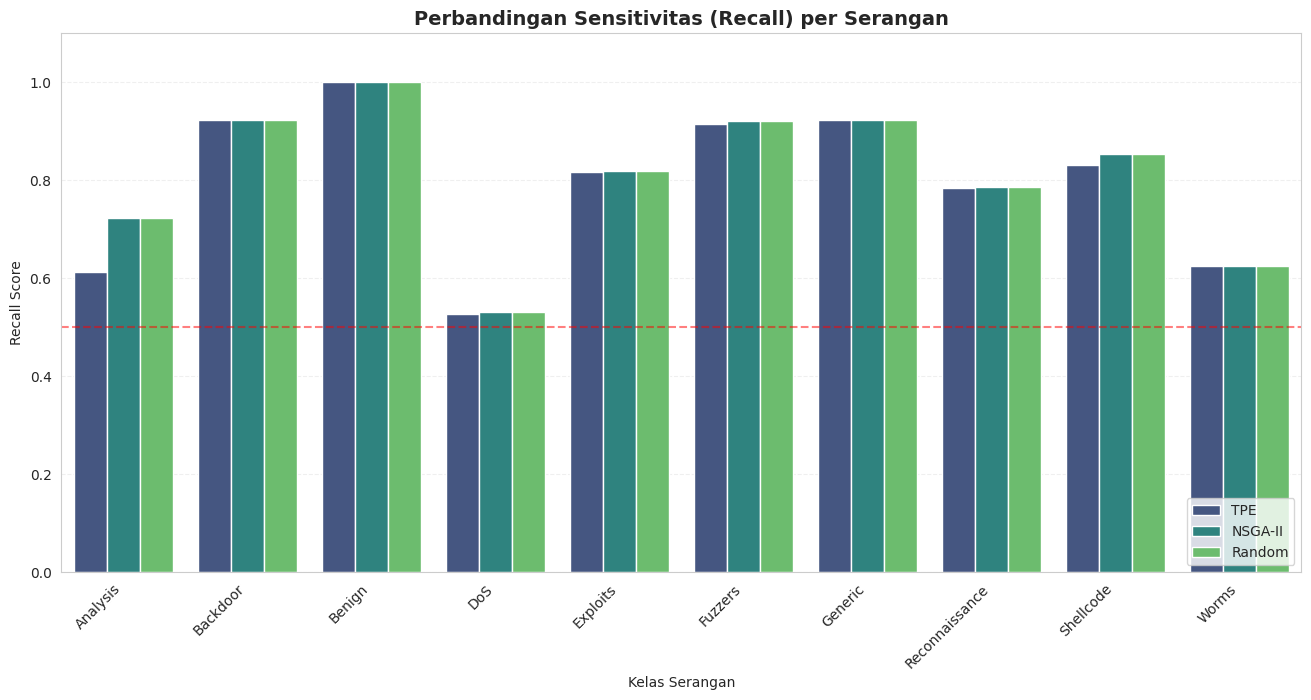

In [13]:
# Cell 12: Recall per Kelas Serangan
print("📊 Analisis Granularitas: Deteksi per Jenis Serangan...")

recall_data = []
for name in ["TPE", "NSGA-II", "Random"]:
    if name in global_models:
        preds = global_models[name][1]
        report = classification_report(y_test_final, preds, target_names=le_target.classes_, output_dict=True)
        for cls in le_target.classes_:
            recall_data.append({
                'Metode': name,
                'Kelas Serangan': cls,
                'Recall Score': report[cls]['recall']
            })

if recall_data:
    df_rec = pd.DataFrame(recall_data)
    plt.figure(figsize=(16, 7))
    sns.barplot(data=df_rec, x='Kelas Serangan', y='Recall Score', hue='Metode', palette='viridis')
    plt.title("Perbandingan Sensitivitas (Recall) per Serangan", fontsize=14, fontweight='bold')
    plt.ylim(0, 1.1)
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.legend(loc='lower right')
    plt.show()

# Visualisasi E: Learning Curve Komparatif (3 Subplots)

📉 Membuat Learning Curve (Cek Stabilitas)...


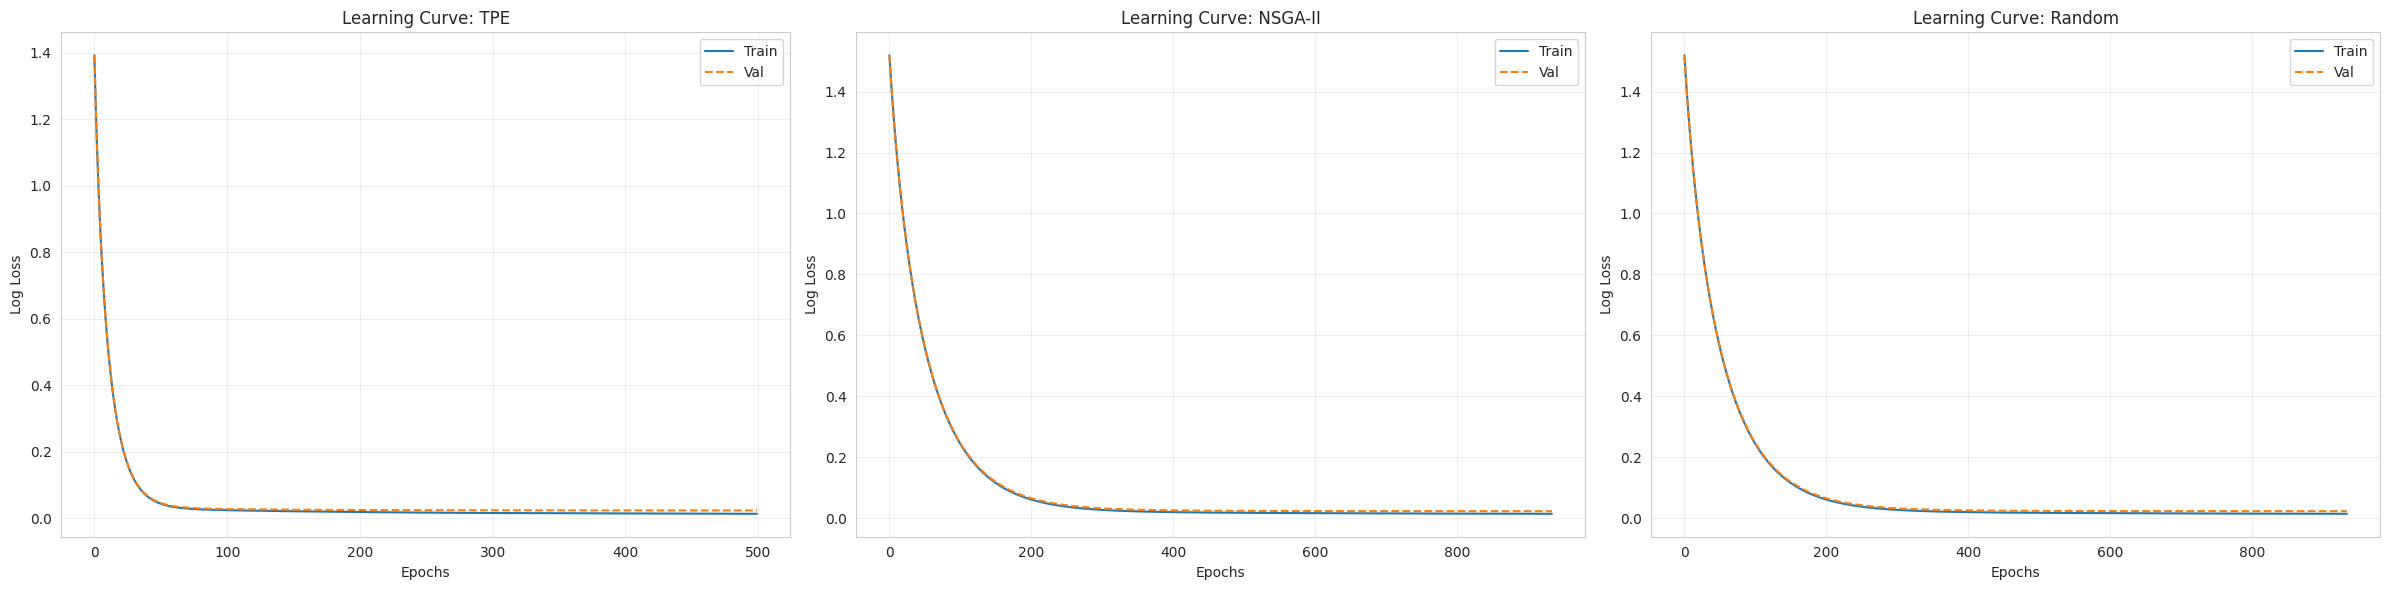

In [14]:
# Cell 13: Learning Curve Comparison
print("📉 Membuat Learning Curve (Cek Stabilitas)...")
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Split visualisasi
X_tr_c, X_val_c, y_tr_c, y_val_c = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)

for i, name in enumerate(["TPE", "NSGA-II", "Random"]):
    if name in global_models:
        model_ref = global_models[name][0]
        # Clone params
        tmp_model = xgb.XGBClassifier(**model_ref.get_params())
        tmp_model.fit(
            X_tr_c, y_tr_c,
            eval_set=[(X_tr_c, y_tr_c), (X_val_c, y_val_c)],
            verbose=False
        )
        # Plot
        res = tmp_model.evals_result()
        epochs = len(res['validation_0']['mlogloss'])
        x_ax = range(epochs)
        axes[i].plot(x_ax, res['validation_0']['mlogloss'], label='Train')
        axes[i].plot(x_ax, res['validation_1']['mlogloss'], label='Val', linestyle='--')
        axes[i].set_title(f"Learning Curve: {name}")
        axes[i].set_xlabel("Epochs"); axes[i].set_ylabel("Log Loss")
        axes[i].legend(); axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualisasi F: Executive Summary Visual (Chart Akhir)

In [15]:
# Cell 14: Executive Summary (Trade-off)
import plotly.graph_objects as go
from plotly.subplots import make_subplots

if 'results' in locals() and not results.empty:
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Bar F1
    fig.add_trace(go.Bar(
        x=results.index, y=results['F1-Score (Macro)'],
        name="Akurasi (F1)", marker_color='#3182bd', opacity=0.8,
        text=results['F1-Score (Macro)'].apply(lambda x: f"{x:.3f}"), textposition='auto'
    ), secondary_y=False)
    
    # Line Time
    fig.add_trace(go.Scatter(
        x=results.index, y=results['Inference Time (s)'],
        name="Inference Time", mode='lines+markers+text',
        marker=dict(size=12, color='#de2d26', symbol='diamond'),
        line=dict(width=3, color='#de2d26'),
        text=results['Inference Time (s)'].apply(lambda x: f"{x:.4f}s"), textposition='top center'
    ), secondary_y=True)
    
    fig.update_layout(title='<b>Executive Summary:</b> Akurasi vs Kecepatan', template='plotly_white')
    fig.update_yaxes(title_text="<b>Macro F1</b>", secondary_y=False, range=[0, 1])
    fig.update_yaxes(title_text="<b>Waktu (s)</b>", secondary_y=True)
    fig.show()

# Visualisasi G: SHAP Values Comparison (Fitur Terpenting)

⏳ Menghitung SHAP Values (Menggunakan KernelExplainer dengan Wrapper)...
   (Estimasi waktu: 1-3 menit per model)
   👉 Generating SHAP for TPE...


  0%|          | 0/50 [00:00<?, ?it/s]

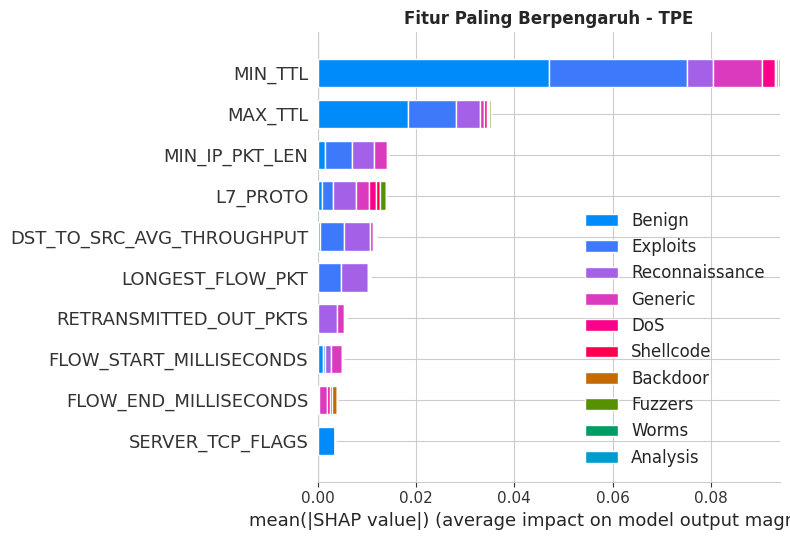

   👉 Generating SHAP for NSGA-II...


  0%|          | 0/50 [00:00<?, ?it/s]

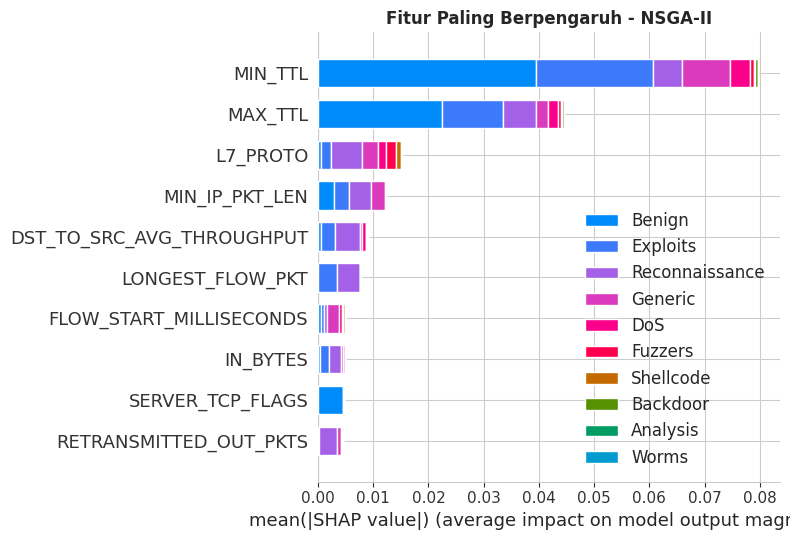

   👉 Generating SHAP for Random...


  0%|          | 0/50 [00:00<?, ?it/s]

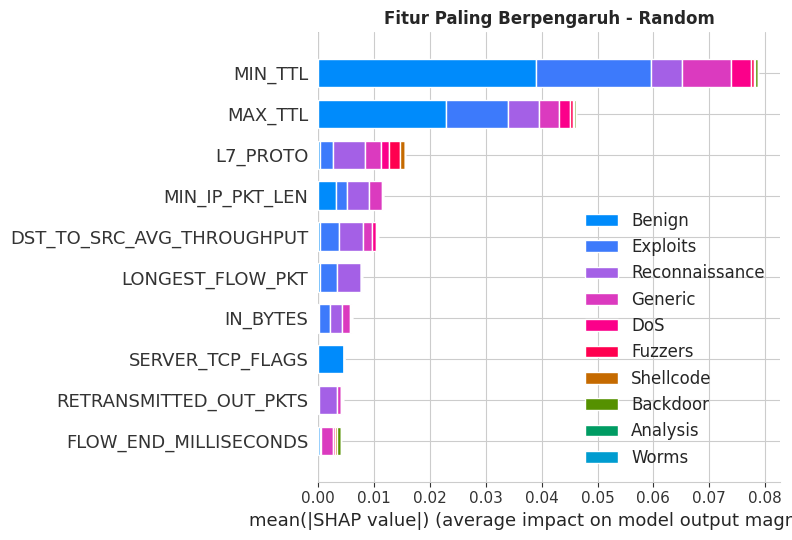

✅ Analisis SHAP Selesai.


In [20]:
# Cell 15 (FIXED v3): SHAP Feature Importance (Wrapper Function)
import shap
import matplotlib.pyplot as plt
import warnings
import pandas as pd

# Matikan warning agar output bersih
warnings.filterwarnings("ignore")

print("⏳ Menghitung SHAP Values (Menggunakan KernelExplainer dengan Wrapper)...")
print("   (Estimasi waktu: 1-3 menit per model)")

# Ambil sampel kecil (50 data) untuk efisiensi
X_samp = X_test_selected.sample(50, random_state=42)
# Simpan nama kolom untuk rekonstruksi nanti
feature_names = X_samp.columns.tolist()

for name in ["TPE", "NSGA-II", "Random"]:
    if name in global_models:
        print(f"   👉 Generating SHAP for {name}...")
        model = global_models[name][0]
        
        # --- SOLUSI UTAMA: Wrapper Function ---
        # 1. Mencegah SHAP mengakses atribut internal model (menghindari AttributeError)
        # 2. Memastikan input kembali jadi DataFrame agar XGBoost tidak bingung soal nama fitur
        def predict_wrapper(data_numpy):
            # SHAP mengubah data jadi numpy array, kita kembalikan ke DataFrame
            if isinstance(data_numpy, np.ndarray):
                data_df = pd.DataFrame(data_numpy, columns=feature_names)
                return model.predict_proba(data_df)
            return model.predict_proba(data_numpy)
        
        # Gunakan KernelExplainer dengan fungsi wrapper tadi, BUKAN model.predict_proba langsung
        explainer = shap.KernelExplainer(predict_wrapper, X_samp)
        
        # Hitung SHAP values
        shap_values = explainer.shap_values(X_samp)
        
        # Visualisasi
        plt.figure(figsize=(10, 5))
        plt.title(f"Fitur Paling Berpengaruh - {name}", fontsize=12, fontweight='bold')
        
        # Plot summary (Bar Chart untuk Multiclass)
        shap.summary_plot(
            shap_values, 
            X_samp, 
            class_names=le_target.classes_,
            plot_type="bar", 
            max_display=10, 
            show=False
        )
        plt.show()

print("✅ Analisis SHAP Selesai.")

# Pengujian A: Uji Signifikansi Statistik (Kruskal-Wallis)

In [22]:
# Cell 16: Uji Statistik (Kruskal-Wallis)
from scipy import stats

print("📊 === UJI SIGNIFIKANSI STATISTIK (Kruskal-Wallis) ===")
# Ambil F1 dari semua trial history (agar sampel cukup banyak)
def get_vals(study): return [t.values[0] for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

v_tpe = get_vals(study_tpe)
v_nsga = get_vals(study_nsga)
v_rnd = get_vals(study_random)

if len(v_tpe) > 5:
    stat, p_val = stats.kruskal(v_tpe, v_nsga, v_rnd)
    print(f"📌 Statistic: {stat:.4f}, P-Value: {p_val:.5f}")
    if p_val < 0.05: print("✅ Ada perbedaan SIGNIFIKAN antar metode (H0 Ditolak).")
    else: print("⚠️ Tidak ada perbedaan signifikan (H0 Diterima).")
else:
    print("❌ Data kurang untuk uji statistik.")

📊 === UJI SIGNIFIKANSI STATISTIK (Kruskal-Wallis) ===
📌 Statistic: 1.0206, P-Value: 0.60032
⚠️ Tidak ada perbedaan signifikan (H0 Diterima).


# Pengujian B: Uji Validitas dengan 5-Fold Cross-Validation

In [27]:
# Cell 17: 5-Fold Cross-Validation (Validitas & Stabilitas)
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import xgboost as xgb

print("🛡️ === UJI VALIDITAS AKHIR (5-Fold Cross-Validation) ===")
print("Tujuan: Memastikan model stabil (low variance) pada berbagai pecahan data.\n")

# Konfigurasi K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# List metode yang akan diuji
methods_to_test = ["TPE", "NSGA-II", "Random"]

for name in methods_to_test:
    if name in global_models:
        print(f"👉 Menguji Stabilitas Model Terbaik ({name})...")
        
        # 1. Ambil model terbaik yang sudah dilatih
        original_model = global_models[name][0]
        
        # 2. Ambil parameternya untuk membuat instance baru
        params = original_model.get_params()
        
        # 3. Buat model baru (kosong) dengan parameter sama
        model_cv = xgb.XGBClassifier(**params)
        
        # 4. Jalankan Cross-Validation
        # PENTING: n_jobs=1 agar tidak crash memory GPU saat multiprocessing
        scores = cross_val_score(
            model_cv, X_selected, y, 
            cv=cv, scoring='f1_macro', n_jobs=1 
        )
        
        print(f"   Skor per Fold : {np.round(scores, 4)}")
        print(f"   ✅ Rata-rata   : {scores.mean():.4f}")
        print(f"   ✅ Std Deviasi : {scores.std():.4f}")
        
        # Interpretasi Stabilitas
        if scores.std() < 0.01:
            print("   Status: 🟢 SANGAT STABIL (Variance < 0.01)")
        elif scores.std() < 0.03:
            print("   Status: 🟡 CUKUP STABIL (Variance < 0.03)")
        else:
            print("   Status: 🔴 KURANG STABIL (Variance Tinggi)")
        print("-" * 50)
    else:
        print(f"⚠️ Model {name} tidak ditemukan untuk CV.")

🛡️ === UJI VALIDITAS AKHIR (5-Fold Cross-Validation) ===
Tujuan: Memastikan model stabil (low variance) pada berbagai pecahan data.

👉 Menguji Stabilitas Model Terbaik (TPE)...
   Skor per Fold : [0.7989 0.7605 0.7756 0.7788 0.7849]
   ✅ Rata-rata   : 0.7797
   ✅ Std Deviasi : 0.0125
   Status: 🟡 CUKUP STABIL (Variance < 0.03)
--------------------------------------------------
👉 Menguji Stabilitas Model Terbaik (NSGA-II)...
   Skor per Fold : [0.7993 0.7562 0.7735 0.7795 0.7817]
   ✅ Rata-rata   : 0.7780
   ✅ Std Deviasi : 0.0139
   Status: 🟡 CUKUP STABIL (Variance < 0.03)
--------------------------------------------------
👉 Menguji Stabilitas Model Terbaik (Random)...
   Skor per Fold : [0.7993 0.7562 0.7735 0.7795 0.7817]
   ✅ Rata-rata   : 0.7780
   ✅ Std Deviasi : 0.0139
   Status: 🟡 CUKUP STABIL (Variance < 0.03)
--------------------------------------------------


# Pengujian C: Analisis Reliabilitas (Cohen's Kappa)

In [28]:
# Cell 18 (IMPROVED): Reliabilitas (Cohen's Kappa) dengan Interpretasi Kualitatif
from sklearn.metrics import cohen_kappa_score
import pandas as pd

print("🛡️ === ANALISIS RELIABILITAS (COHEN'S KAPPA) ===")
print("Tujuan: Mengukur kesepakatan prediksi model dengan label asli (mengoreksi faktor kebetulan).")
print("Acuan Interpretasi: Landis & Koch (1977)\n")

# Fungsi Standar Baku Interpretasi Kappa
def get_kappa_interpretation(score):
    if score < 0: return "Poor (Buruk/Lebih buruk dari acak)"
    elif score <= 0.20: return "Slight (Sangat Lemah)"
    elif score <= 0.40: return "Fair (Cukup)"
    elif score <= 0.60: return "Moderate (Sedang)"
    elif score <= 0.80: return "Substantial (Kuat)"
    else: return "Almost Perfect (Sangat Kuat / Hampir Sempurna)"

kappa_results = []

# Hitung untuk setiap metode yang tersedia
for name in ["TPE", "NSGA-II", "Random"]:
    if name in global_models:
        y_pred = global_models[name][1]
        score = cohen_kappa_score(y_test_final, y_pred)
        interpretation = get_kappa_interpretation(score)
        
        kappa_results.append({
            "Metode": name,
            "Kappa Score": score,
            "Interpretasi (Landis & Koch)": interpretation
        })

# Tampilkan dalam bentuk Tabel Dataframe agar rapi di Laporan
if kappa_results:
    df_kappa = pd.DataFrame(kappa_results).set_index("Metode")
    display(df_kappa)
    
    # Kesimpulan Otomatis untuk Skripsi
    best_model = df_kappa["Kappa Score"].idxmax()
    best_score = df_kappa["Kappa Score"].max()
    print(f"\n💡 KESIMPULAN: Model terbaik adalah **{best_model}** dengan skor **{best_score:.4f}**.")
    if best_score > 0.8:
        print("   Ini menunjukkan tingkat reliabilitas yang 'Hampir Sempurna'. Sangat layak untuk deployment.")
    elif best_score > 0.6:
        print("   Ini menunjukkan tingkat reliabilitas yang 'Kuat'. Cukup baik untuk skripsi.")
else:
    print("⚠️ Belum ada model yang dilatih untuk dievaluasi.")

🛡️ === ANALISIS RELIABILITAS (COHEN'S KAPPA) ===
Tujuan: Mengukur kesepakatan prediksi model dengan label asli (mengoreksi faktor kebetulan).
Acuan Interpretasi: Landis & Koch (1977)



,Kappa Score,Interpretasi (Landis & Koch)
Metode,,
TPE,0.918781,Almost Perfect (Sangat Kuat / Hampir Sempurna)
NSGA-II,0.920665,Almost Perfect (Sangat Kuat / Hampir Sempurna)
Random,0.920665,Almost Perfect (Sangat Kuat / Hampir Sempurna)



💡 KESIMPULAN: Model terbaik adalah **NSGA-II** dengan skor **0.9207**.
   Ini menunjukkan tingkat reliabilitas yang 'Hampir Sempurna'. Sangat layak untuk deployment.


# Save Model

In [37]:
# Cell 20 (FINAL COMPLETE): MASTER SAVER - Visualisasi, Model, & DATA MENTAH (CSV)
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import optuna

print("💾 MEMULAI PROSES PENYIMPANAN LENGKAP (Artefak + Data Mentah)...")

# 1. Setup Folder Struktur
base_dir = "hasil_skripsi_artefak"
vis_dir = f"{base_dir}/visualisasi"
data_dir = f"{base_dir}/data_mentah" # Folder baru untuk Excel/CSV
os.makedirs(vis_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

# ==========================================
# A. SIMPAN DATA TABULAR (PENTING UNTUK BAB 4)
# ==========================================
print("   📊 Menyimpan Data Tabular (CSV/Excel)...")

# 1. Tabel Rekapitulasi Akhir (F1, Time, Akurasi)
if 'results' in locals() and not results.empty:
    results.to_csv(f"{data_dir}/rekap_hasil_akhir.csv")
    print("      -> rekap_hasil_akhir.csv tersimpan.")

# 2. Tabel Kappa (Reliabilitas)
if 'df_kappa' in locals() and not df_kappa.empty:
    df_kappa.to_csv(f"{data_dir}/rekap_kappa.csv")
    print("      -> rekap_kappa.csv tersimpan.")

# 3. History Trial Optuna (Semua Percobaan)
for name, study in [("TPE", locals().get('study_tpe')), 
                    ("NSGA-II", locals().get('study_nsga')), 
                    ("Random", locals().get('study_random'))]:
    if study is not None:
        try:
            df_hist = study.trials_dataframe()
            df_hist.to_csv(f"{data_dir}/history_trials_{name}.csv")
            print(f"      -> History {name} tersimpan ({len(df_hist)} rows).")
        except: pass

# 4. Classification Report Text (Detail per Kelas)
for name in ["TPE", "NSGA-II", "Random"]:
    if name in global_models:
        rpt = classification_report(y_test_final, global_models[name][1], target_names=le_target.classes_)
        with open(f"{data_dir}/report_detail_{name}.txt", "w") as f:
            f.write(rpt)

# ==========================================
# B. SIMPAN PLOTLY (Interaktif HTML & Statis PNG)
# ==========================================
print("   📸 Menyimpan Grafik Plotly...")

def save_plotly(fig_obj, filename):
    if fig_obj:
        fig_obj.write_html(f"{vis_dir}/{filename}.html")
        try: fig_obj.write_image(f"{vis_dir}/{filename}.png", scale=3)
        except: pass

# Recreate & Save Pareto
try:
    import plotly.graph_objects as go
    fig_pareto = go.Figure()
    def add_trace(study, name, color, sym):
        if study:
            valid = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
            fig_pareto.add_trace(go.Scatter(x=[t.values[1] for t in valid], y=[t.values[0] for t in valid],
                                     mode='markers', name=name, marker=dict(size=10, color=color, symbol=sym)))
    
    add_trace(locals().get('study_nsga'), "NSGA-II", "red", "circle")
    add_trace(locals().get('study_tpe'), "TPE", "blue", "x")
    add_trace(locals().get('study_random'), "Random", "gray", "square")
    fig_pareto.update_layout(title='Pareto Front Comparison', xaxis_title='Time', yaxis_title='F1-Score', template='plotly_white')
    save_plotly(fig_pareto, "1_pareto_front")
except Exception as e: print(f"⚠️ Gagal save Pareto: {e}")

# Recreate & Save Summary
try:
    if 'results' in locals() and not results.empty:
        from plotly.subplots import make_subplots
        fig_exec = make_subplots(specs=[[{"secondary_y": True}]])
        fig_exec.add_trace(go.Bar(x=results.index, y=results['F1-Score (Macro)'], name="F1", marker_color='#3182bd'), secondary_y=False)
        fig_exec.add_trace(go.Scatter(x=results.index, y=results['Inference Time (s)'], name="Time", line=dict(color='#de2d26')), secondary_y=True)
        fig_exec.update_layout(title='Executive Summary', template='plotly_white')
        save_plotly(fig_exec, "2_executive_summary")
except Exception as e: print(f"⚠️ Gagal save Summary: {e}")

# ==========================================
# C. SIMPAN MATPLOTLIB / SEABORN
# ==========================================
print("   📸 Menyimpan Grafik Matplotlib...")
def new_fig(w=10, h=6): plt.figure(figsize=(w, h))

# Confusion Matrix
try:
    for name in ["TPE", "NSGA-II", "Random"]:
        if name in global_models:
            new_fig(8, 6)
            cm = confusion_matrix(y_test_final, global_models[name][1])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
            plt.title(f"Confusion Matrix - {name}"); plt.tight_layout()
            plt.savefig(f"{vis_dir}/3_cm_{name}.png", dpi=300); plt.close()
except: pass

# Learning Curve
try:
    for name in ["TPE", "NSGA-II", "Random"]:
        if name in global_models:
            model = global_models[name][0]
            if hasattr(model, 'evals_result'):
                results_ev = model.evals_result()
                if results_ev:
                    new_fig(8, 5)
                    plt.plot(results_ev['validation_0']['mlogloss'], label='Train')
                    if 'validation_1' in results_ev: plt.plot(results_ev['validation_1']['mlogloss'], label='Val')
                    plt.title(f"Learning Curve - {name}"); plt.legend(); plt.grid(True)
                    plt.savefig(f"{vis_dir}/4_learning_curve_{name}.png", dpi=300); plt.close()
except: pass

# Granularity Recall
try:
    recall_data = []
    for name in ["TPE", "NSGA-II", "Random"]:
        if name in global_models:
            rpt = classification_report(y_test_final, global_models[name][1], target_names=le_target.classes_, output_dict=True)
            for cls in le_target.classes_:
                recall_data.append({'Metode': name, 'Kelas': cls, 'Recall': rpt[cls]['recall']})
    if recall_data:
        new_fig(14, 7)
        sns.barplot(data=pd.DataFrame(recall_data), x='Kelas', y='Recall', hue='Metode', palette='viridis')
        plt.title("Granularitas Recall"); plt.xticks(rotation=45); plt.tight_layout()
        plt.savefig(f"{vis_dir}/5_recall_granularity.png", dpi=300); plt.close()
except: pass

# SHAP & Distribusi (Mengandalkan variabel di memori)
try:
    if 'shap_values' in locals() and 'X_samp' in locals():
        new_fig(10, 6)
        shap.summary_plot(shap_values, X_samp, class_names=le_target.classes_, show=False)
        plt.tight_layout(); plt.savefig(f"{vis_dir}/6_shap_summary.png", dpi=300); plt.close()
    
    new_fig(12, 5)
    counts = pd.Series(y_train).value_counts().sort_index()
    sns.barplot(x=le_target.classes_, y=counts.values, palette='viridis')
    plt.yscale('log'); plt.title("Distribusi Data"); plt.xticks(rotation=45); plt.tight_layout()
    plt.savefig(f"{vis_dir}/7_data_distribution.png", dpi=300); plt.close()
except: pass

# ==========================================
# D. ZIP & FINISH
# ==========================================
print("\n📦 Mengompres Output menjadi ZIP...")
shutil.make_archive("HASIL_SKRIPSI_FINAL", 'zip', base_dir)

print(f"\n🎉 ALL DONE! Silakan download 'HASIL_SKRIPSI_FINAL.zip'.")
print("   Isi ZIP sekarang lebih lengkap:")
print("   1. 📂 /visualisasi : Gambar PNG/HTML.")
print("   2. 📂 /data_mentah : CSV & Excel (rekap_hasil_akhir.csv, history_trials.csv).")
print("   3. 📄 Model & Params JSON.")

💾 MEMULAI PROSES PENYIMPANAN LENGKAP (Artefak + Data Mentah)...
   📊 Menyimpan Data Tabular (CSV/Excel)...
      -> rekap_hasil_akhir.csv tersimpan.
      -> rekap_kappa.csv tersimpan.
      -> History TPE tersimpan (30 rows).
      -> History NSGA-II tersimpan (30 rows).
      -> History Random tersimpan (30 rows).
   📸 Menyimpan Grafik Plotly...
   📸 Menyimpan Grafik Matplotlib...

📦 Mengompres Output menjadi ZIP...

🎉 ALL DONE! Silakan download 'HASIL_SKRIPSI_FINAL.zip'.
   Isi ZIP sekarang lebih lengkap:
   1. 📂 /visualisasi : Gambar PNG/HTML.
   2. 📂 /data_mentah : CSV & Excel (rekap_hasil_akhir.csv, history_trials.csv).
   3. 📄 Model & Params JSON.


<Figure size 1000x600 with 0 Axes>